# 1. IMPORTS
---

## 1.1. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import shap
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import scikitplot as skplt
from sklearn.utils.class_weight import compute_class_weight
import optuna
import pickle
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Boruta numpy fix problem
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

## 1.2. Helper functions

In [3]:
def cross_val_rescaling_evaluation(X, y, model, scalers, n_splits=5, early_stop=False):
    """
    Evaluates a model using cross-validation with feature scaling and returns a DataFrame with performance metrics.

    Parameters:
    X (pd.DataFrame or np.ndarray): Feature matrix.
    y (pd.Series or np.ndarray): Target vector.
    model (sklearn-like estimator): The model to evaluate.
    scalers (list of tuples): List of (scaler, columns) tuples where 'scaler' is an instance of a scaler and 'columns' is a list of columns to apply the scaler to.
    n_splits (int, optional): Number of cross-validation splits. Default is 5.
    early_stop (int, optional): Early stopping decision. If False, early stopping is not used. Default is False.

    Returns:
    pd.DataFrame: DataFrame containing the cross-validation results for ROC AUC, precision, recall, and F1 score.
    """
    # Preprocessors
    transformers = [(scaler.__class__.__name__.lower(), scaler, cols) for scaler, cols in scalers]
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

    # Define cross-validation strategy
    kf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

    # Define lists of folds of model
    roc_auc_folds = []
    precision_folds = []
    recall_folds = []
    f1_folds = []

    for train_idx, val_idx in kf.split(X, y):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            X_train_fold = preprocessor.fit_transform(X_train_fold)
            X_val_fold = preprocessor.transform(X_val_fold)

            if early_stop == False:
                model.fit(X_train_fold, y_train_fold)
            elif model.__class__.__name__ == 'XGBClassifier':
                model.fit(X_train_fold, y_train_fold, 
                          eval_set=[(X_val_fold, y_val_fold)],
                          verbose=False)
            elif model.__class__.__name__ == 'CatBoostClassifier':
                model.fit(X_train_fold, y_train_fold, 
                          eval_set=[(X_val_fold, y_val_fold)],
                          verbose_eval=False)
            else:
                model.fit(X_train_fold, y_train_fold,
                          eval_set=[(X_val_fold, y_val_fold)])

            y_pred_fold = model.predict(X_val_fold)
            y_predict_proba_fold = model.predict_proba(X_val_fold)[:, 1]

            roc_auc_folds.append(roc_auc_score(y_val_fold, y_predict_proba_fold))
            precision_folds.append(precision_score(y_val_fold, y_pred_fold))
            recall_folds.append(recall_score(y_val_fold, y_pred_fold))
            f1_folds.append(f1_score(y_val_fold, y_pred_fold))

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(columns=['test_roc_auc_score', 
                                       'test_precision_score', 'test_recall_score', 
                                       'test_f1_score'])
    results_df['test_roc_auc_score'] = roc_auc_folds
    results_df['test_precision_score'] = precision_folds
    results_df['test_recall_score'] = recall_folds
    results_df['test_f1_score'] = f1_folds

    return results_df




def make_cv_model_results_df(models, X, y, scalers, n_splits=5, early_stop_decisions=None):
    """
    Evaluates multiple models using cross-validation with feature scaling and returns a DataFrame with performance metrics.

    Parameters:
    models (list): List of machine learning models to be evaluated.
    X (pd.DataFrame or np.ndarray): Feature matrix.
    y (pd.Series or np.ndarray): Target vector.
    scalers (list of tuples): List of (scaler, columns) tuples where 'scaler' is an instance of a scaler and 'columns' is a list of columns to apply the scaler to.
    n_splits (int, optional): Number of cross-validation splits. Default is 5.
    early_stop_decisions (list, optional): List of early stopping decisions for each model. If None, early stopping is not used for any model. Default is None.

    Returns:
    pd.DataFrame: DataFrame containing the model names and their cross-validation performance metrics (ROC AUC, precision, recall, F1 score).
    """
    models_str = []
    
    precisions_cv = []
    recalls_cv = []
    f1s_cv = []
    roc_aucs_cv = []

    if early_stop_decisions != None:
        for model, early_stop in zip(models, early_stop_decisions):
            models_str.append(model.__class__.__name__)
            results = cross_val_rescaling_evaluation(X, y, model, scalers, n_splits, early_stop)

            # Get the mean and standard deviation of the metrics
            p = f'{round(results["test_precision_score"].mean(), 3)} +/- {round(results["test_precision_score"].std(), 3)}'
            r = f'{round(results["test_recall_score"].mean(), 3)} +/- {round(results["test_recall_score"].std(), 3)}'
            f = f'{round(results["test_f1_score"].mean(), 3)} +/- {round(results["test_f1_score"].std(), 3)}'
            roc = f'{round(results["test_roc_auc_score"].mean(), 3)} +/- {round(results["test_roc_auc_score"].std(), 3)}'

            # Add the results to the lists
            precisions_cv.append(p)
            recalls_cv.append(r)
            f1s_cv.append(f)
            roc_aucs_cv.append(roc)
    
    else:
        for model in models:
            models_str.append(model.__class__.__name__)
            results = cross_val_rescaling_evaluation(X, y, model, scalers, n_splits)

            # Get the mean and standard deviation of the metrics
            p = f'{round(results["test_precision_score"].mean(), 3)} +/- {round(results["test_precision_score"].std(), 3)}'
            r = f'{round(results["test_recall_score"].mean(), 3)} +/- {round(results["test_recall_score"].std(), 3)}'
            f = f'{round(results["test_f1_score"].mean(), 3)} +/- {round(results["test_f1_score"].std(), 3)}'
            roc = f'{round(results["test_roc_auc_score"].mean(), 3)} +/- {round(results["test_roc_auc_score"].std(), 3)}'

            # Add the results to the lists
            precisions_cv.append(p)
            recalls_cv.append(r)
            f1s_cv.append(f)
            roc_aucs_cv.append(roc)
    
    # Final DataFrame with results
    results_df = pd.DataFrame({
        'model': models_str,
        'roc_auc_cv': roc_aucs_cv,
        'precision_cv': precisions_cv,
        'recall_cv': recalls_cv,
        'f1_cv': f1s_cv
    })
    
    return results_df




def make_test_model_results_df(models, X_train, y_train, X_test, y_test, eval_sets=None):
    """
    Fits multiple models on the training set, evaluates them on the test set, and 
    returns a DataFrame with performance metrics.

    Parameters:
    models (list): List of machine learning models to be evaluated.
    X_train (pd.DataFrame or np.ndarray): Training features.
    y_train (pd.Series or np.ndarray): Training target.
    X_test (pd.DataFrame or np.ndarray): Test features.
    y_test (pd.Series or np.ndarray): Test target.
    eval_sets (list, optional): List of tuples containing validation data to be used for early stopping, if applicable. Default is None.

    Returns:
    pd.DataFrame: DataFrame containing the model names and their performance metrics (AUC, precision, recall, F1 score) on the test set.
    """
    results_test_df = pd.DataFrame(columns=['model', 'auc_test', 'precision_test', 
                                            'recall_test', 'f1_test'])
    auc_tests = []
    test_models = []
    precision_tests = []
    recall_tests = []
    f1_tests = []

    # Fitting all the models on the training set and evaluating on the test set
    if eval_sets == None:
        eval_sets = [None] * len(models)
        
    for model, eval_set in zip(models, eval_sets):
        if eval_set == None:
            model.fit(X_train, y_train)
        elif model.__class__.__name__ == 'CatBoostClassifier':
            model.fit(X_train, y_train, eval_set=eval_set, verbose_eval=False)
        elif model.__class__.__name__ == 'XGBClassifier':
            model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
        else:
            model.fit(X_train, y_train, eval_set=eval_set)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        # Calculate and round scores for the test set
        m_str = model.__class__.__name__
        auc = round(roc_auc_score(y_test, y_pred_proba[:, 1]), 3)
        p = round(precision_score(y_test, y_pred, zero_division=1), 3)
        r = round(recall_score(y_test, y_pred, zero_division=1), 3)
        f1 = round(f1_score(y_test, y_pred, zero_division=1), 3)

        # Append the scores to their respective lists
        auc_tests.append(auc)
        test_models.append(m_str)
        precision_tests.append(p)
        recall_tests.append(r)
        f1_tests.append(f1)

    # Fill the DataFrame with the results
    results_test_df['model'] = test_models
    results_test_df['auc_test'] = auc_tests
    results_test_df['precision_test'] = precision_tests
    results_test_df['recall_test'] = recall_tests
    results_test_df['f1_test'] = f1_tests

    return results_test_df




def plot_cumulative_gain_of(models, X_test, y_test, figsize=(12, 8), subx=0, suby=0, drop_axes=False):
    """
    Plots the cumulative gain curves for a list of models on the test data.

    Parameters:
    - models (list): A list of trained models to evaluate.
    - X_test (array-like): Test feature data.
    - y_test (array-like): True labels for the test data.
    - figsize (tuple, optional): Figure size of the plot. Default is (12, 8).
    - drop_axes (bool or list, optional): Indices of subplot axes to drop (turn off). Default is False (no axes are dropped).

    Returns:
    None. Displays the cumulative gain plots.
    """
    model_dict = {model.__class__.__name__:model for model in models}

    fig, axes = plt.subplots(subx, suby, figsize=figsize)
    axes = axes.flatten()

    for ax, (model_name, model) in zip(axes, model_dict.items()):

        # Predict proba
        y_pred_proba = model.predict_proba(X_test)

        # Cummulative gain curve
        skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba, ax=ax, title=model_name)
    
    if drop_axes != False:
        for i in drop_axes:
            axes[i].set_axis_off()

    plt.tight_layout()
    plt.show()

# 2. MACHINE LEARNING MODELING
---

## 2.1. Train and test set division

In [4]:
# Final X features
final_x_feat = [
    'age', 'gender', 'famous_region',
    'vehicle_damage', 'vehicle_age',
    'policy_sales_channel2_124',
    'policy_sales_channel2_152', 
    'policy_sales_channel2_26'
]

# Define the scalers and the columns they should be applied to
scalers = [
    (MinMaxScaler(), ['age'])
]

In [5]:
# Import train and test data
X_train_rescaled = pd.read_csv('../data/processed/X_train_rescaled.csv')
X_train_ids = X_train_rescaled['id'].values

X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')

X_test_rescaled = pd.read_csv('../data/processed/X_test_rescaled.csv')
X_test_ids = X_test_rescaled['id'].values

X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

# Drop ID
for dataset in [X_train, X_test, X_train_rescaled, X_test_rescaled]:
    dataset.drop('id', axis=1, inplace=True)

# Get necessary features from X_train and X_test
X_train = X_train[final_x_feat]
X_train_rescaled = X_train_rescaled[final_x_feat]

X_test = X_test[final_x_feat]
X_test_rescaled = X_test_rescaled[final_x_feat]

# Data to numpy
X_train_rescaled_n = X_train_rescaled.values
y_train_n = y_train.values.ravel()

X_test_rescaled_n = X_test_rescaled.values
y_test_n = y_test.values.ravel()

There are **7 categorical** and **1 numerical** features. I think that **CatBoost** will be a good model to try! I'll see other models too, like **Random Forest**, **XGBoost**, **Extra Trees**, **KNN** and **Logistic Regression**.

## 2.2. Cross-validation and Testing

In [6]:
# Calculate the ratio of negative class to positive class
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]

# Define the models
xgb = XGBClassifier(scale_pos_weight=ratio, max_depth=6)
rf = RandomForestClassifier(class_weight='balanced', max_depth=6)
lr = LogisticRegression(class_weight='balanced')
et = ExtraTreesClassifier(class_weight='balanced', max_depth=6)
knn = KNeighborsClassifier(n_neighbors=7)

cb = CatBoostClassifier(
    iterations=1000,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=5,  # Depth of the trees
    l2_leaf_reg=3,  # L2 regularization term
    eval_metric='AUC',  # Evaluation metric
    auto_class_weights='Balanced',  # Automatically adjust weights for classes to balance
    random_seed=42,  # Random seed for reproducibility
    logging_level='Silent'  # Suppress training log
)

models = [cb, xgb, rf, lr, et, knn]

In [7]:
# Metrics results
results_cv_df = make_cv_model_results_df(models, X_train, y_train_n, scalers)
results_test_df = make_test_model_results_df(models, X_train_rescaled, y_train_n, 
                                             X_test_rescaled, y_test_n)

# Final results df
results_df = results_cv_df.merge(results_test_df, on='model', how='left')

# Ordering variables
results_df = results_df[['model', 'roc_auc_cv', 'auc_test',
                         'precision_cv', 'precision_test',
                         'recall_cv', 'recall_test',
                         'f1_cv', 'f1_test']]

In [8]:
display(results_df)

,model,roc_auc_cv,auc_test,precision_cv,precision_test,recall_cv,recall_test,f1_cv,f1_test
0,CatBoostClassifier,0.829 +/- 0.001,0.828,0.203 +/- 0.001,0.204,0.914 +/- 0.003,0.914,0.333 +/- 0.002,0.333
1,XGBClassifier,0.828 +/- 0.001,0.827,0.204 +/- 0.001,0.204,0.911 +/- 0.003,0.912,0.333 +/- 0.002,0.333
2,RandomForestClassifier,0.828 +/- 0.002,0.825,0.204 +/- 0.001,0.204,0.91 +/- 0.003,0.906,0.333 +/- 0.002,0.333
3,LogisticRegression,0.815 +/- 0.002,0.814,0.193 +/- 0.001,0.194,0.915 +/- 0.003,0.919,0.319 +/- 0.002,0.321
4,ExtraTreesClassifier,0.825 +/- 0.002,0.824,0.202 +/- 0.002,0.203,0.912 +/- 0.006,0.911,0.33 +/- 0.002,0.332
5,KNeighborsClassifier,0.728 +/- 0.004,0.719,0.253 +/- 0.006,0.243,0.046 +/- 0.007,0.044,0.077 +/- 0.01,0.075


## 2.3. Cumulative gain plots

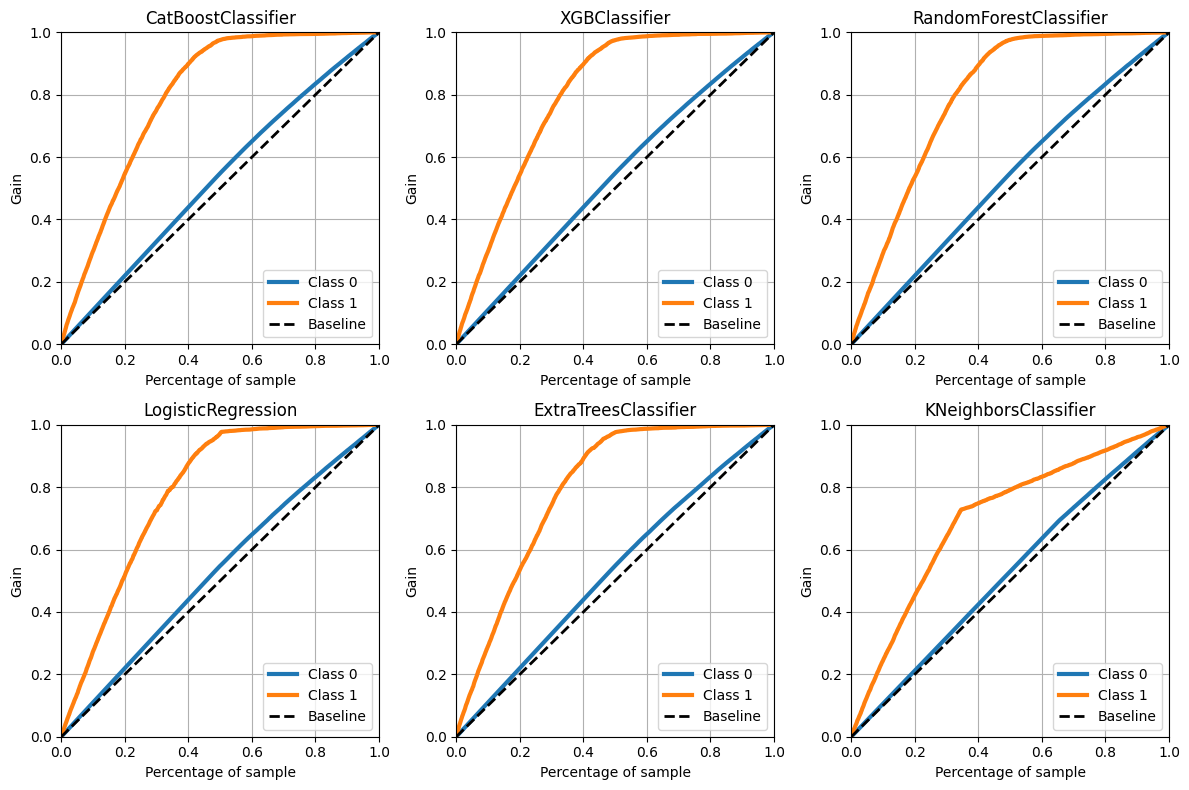

In [9]:
# All cumulative gain plots
plot_cumulative_gain_of(models, X_test_rescaled, y_test, subx=2, suby=3)

**NOTE**

We just want to get the best customers for cross-sell. So, the contact will be by propensity, that's why the cumulative plot is so important! 

In my case, the tree based models are very similar, the only one that can beat them is Logistic Regression:
- If we contact **20\%** of all the sample, then we can get almost **60\%** of interest in vehicle insurance
- If we contact **40\%** of all the sample, then we can get almost **90\%** of interest in vehicle insurance

**DECISION**

Make hyperparameter tunning for almost all these models.

I'll not try for:
- KNeighbors because of its worst performance
- Random Forest because its time execution

And then, I'll choose the best.

## 2.4. Hyperparameter tuning

I'll use **Optuna** to get the best set of hyperparameters.

### 2.4.1. CatBoost

In [10]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_n), y=y_train_n)
class_weights_dict = dict(enumerate(class_weights))

In [11]:
def objective_catboost(trial, X_train=X_train, y_train=y_train_n, class_weights_dict=class_weights_dict):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.3),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-9, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100)
    }

    model = CatBoostClassifier(
        **params,
        class_weights=class_weights_dict,
        early_stopping_rounds=50,
        verbose=0,
        random_state=42
    )

    # Define the scalers and the columns they should be applied to
    scalers = [
        (MinMaxScaler(), ['age'])
    ]

    # Define the column transformer with specified scalers
    transformers = [(scaler.__class__.__name__.lower(), scaler, cols) for scaler, cols in scalers]
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
    
    # Define cross-validation strategy
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        X_train_fold = preprocessor.fit_transform(X_train_fold)
        X_val_fold = preprocessor.transform(X_val_fold)

        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=0)
        y_predict_proba = model.predict_proba(X_val_fold)[:, 1]
        scores.append(roc_auc_score(y_val_fold, y_predict_proba))
    
    return np.mean(scores)

In [12]:
## WARNING: 1h to run
#study = optuna.create_study(direction='maximize')
#study.optimize(objective_catboost, n_trials=50)
#
#print('Number of finished trials:', len(study.trials))
#print('Best trial:', study.best_trial.params)

In [13]:
# Best catboost params from optuna - ROC AUC: 0.8309
best_catboost_params = {
    'iterations': 311, 
    'depth': 6, 
    'learning_rate': 0.04772516436776049, 
    'random_strength': 8.35660360558705, 
    'l2_leaf_reg': 51.72660544188361, 
    'subsample': 0.7852968586384578, 
    'colsample_bylevel': 0.6713810602285384, 
    'min_data_in_leaf': 54,
    'auto_class_weights':'Balanced',
    'early_stopping_rounds':50,
    'logging_level':'Silent',
    'random_state':42
}

### 2.4.2. XGBoost

In [14]:
# Compute class weights
scale_pos_weight = class_weights[1] / class_weights[0]

In [15]:
def objective_xgboost(trial, X_train=X_train, y_train=y_train_n, scale_pos_weight=scale_pos_weight):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.3),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 10)
    }

    model = XGBClassifier(**params, scale_pos_weight=scale_pos_weight, 
                          early_stopping_rounds=50, random_state=42)

    # Define the scalers and the columns they should be applied to
    scalers = [
    (MinMaxScaler(), ['age'])
    ]

    # Define the column transformer with specified scalers
    transformers = [(scaler.__class__.__name__.lower(), scaler, cols) for scaler, cols in scalers]
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

    # Define cross-validation strategy
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        X_train_fold = preprocessor.fit_transform(X_train_fold)
        X_val_fold = preprocessor.transform(X_val_fold)

        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=0)
        y_predict_proba = model.predict_proba(X_val_fold)[:, 1]
        scores.append(roc_auc_score(y_val_fold, y_predict_proba))
    
    return np.mean(scores)

In [16]:
## 13 min to run
#study = optuna.create_study(direction='maximize')
#study.optimize(objective_xgboost, n_trials=50)
#
#print('Number of finished trials:', len(study.trials))
#print('Best trial:', study.best_trial.params)

In [17]:
# Best xgboost params from optuna - ROC AUC: 0.8307
best_xgboost_params = {
    'n_estimators': 496, 
    'max_depth': 7, 
    'learning_rate': 0.04137503245696931, 
    'colsample_bytree': 0.7559959100018439, 
    'subsample': 0.6514179026117035, 
    'gamma': 7.0402970338352615, 
    'min_child_weight': 6, 
    'reg_alpha': 1.2727106483269806, 
    'reg_lambda': 0.0290784764275906, 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'booster': 'gbtree',
    'verbosity': 0,
    'early_stopping_rounds':50,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42
}

### 2.4.3. Logistic Regression

In [18]:
def objective_lr(trial, X_train=X_train, y_train=y_train_n, class_weight=class_weights_dict):
    params = {
        'C': trial.suggest_loguniform('C', 1e-5, 100),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['saga'])
    }

    model = LogisticRegression(**params, class_weight=class_weight, random_state=42)

    # Define the scalers and the columns they should be applied to
    scalers = [
    (MinMaxScaler(), ['age'])
    ]

    # Define the column transformer with specified scalers
    transformers = [(scaler.__class__.__name__.lower(), scaler, cols) for scaler, cols in scalers]
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
    
    # Create a pipeline that first applies the preprocessor and then the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Define cross-validation strategy
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    
    # Run cross-validation
    scores = cross_validate(pipeline, X_train, y_train, cv=kf, scoring='roc_auc')

    return np.mean(scores['test_score'])

In [19]:
## WARNING: 26 min to run
#study = optuna.create_study(direction='maximize')
#study.optimize(objective_lr, n_trials=50)
#
#print('Number of finished trials:', len(study.trials))
#print('Best trial:', study.best_trial.params)

In [20]:
# Best logistic regression params from optuna - ROC AUC: 0.8153
best_lr_params = {
    'C': 89.23665560528723, 
    'penalty': 'l2', 
    'solver': 'saga',
    'random_state':42
}

### 2.4.4. Extra Trees

In [21]:
def objective_extra_trees(trial, X_train=X_train, y_train=y_train_n):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    model = ExtraTreesClassifier(
        **params,
        class_weight='balanced',
        random_state=42
    )

    # Define the scalers and the columns they should be applied to
    scalers = [
        (MinMaxScaler(), ['age'])
    ]

    # Define the column transformer with specified scalers
    transformers = [(scaler.__class__.__name__.lower(), scaler, cols) for scaler, cols in scalers]
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
    
    # Define cross-validation strategy
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        X_train_fold = preprocessor.fit_transform(X_train_fold)
        X_val_fold = preprocessor.transform(X_val_fold)

        model.fit(X_train_fold, y_train_fold)
        y_predict_proba = model.predict_proba(X_val_fold)[:, 1]
        scores.append(roc_auc_score(y_val_fold, y_predict_proba))
    
    return np.mean(scores)

In [22]:
## WARNING: 5h to run
#study = optuna.create_study(direction='maximize')
#study.optimize(objective_extra_trees, n_trials=50)
#
#print('Number of finished trials:', len(study.trials))
#print('Best trial:', study.best_trial.params)

In [23]:
# Best extra trees params from optuna - ROC AUC: 0.8304
best_extra_trees_params = {
    'n_estimators': 379, 
    'max_depth': 10, 
    'min_samples_split': 9, 
    'min_samples_leaf': 2, 
    'max_features': None, 
    'bootstrap': True, 
    'class_weight':'balanced',
    'random_state':42
}

## 2.5. Final models comparison

In [24]:
# Define the models
cb2 = CatBoostClassifier(**best_catboost_params)
xgb2 = XGBClassifier(**best_xgboost_params)
lr2 = LogisticRegression(**best_lr_params)
et2 = ExtraTreesClassifier(**best_extra_trees_params)

models2 = [cb2, xgb2, lr2, et2]

In [25]:
# Metrics results
results_cv_df2 = make_cv_model_results_df(models2, X_train, y_train_n, scalers, 
                                          early_stop_decisions=[True, True, False, False])

results_test_df2 = make_test_model_results_df(models2, X_train_rescaled, y_train_n, 
                                              X_test_rescaled, y_test_n,
                                              eval_sets=[[(X_test_rescaled, y_test_n)],
                                                         [(X_test_rescaled, y_test_n)],
                                                         None, None])

# Final results df
results_df2 = results_cv_df2.merge(results_test_df2, on='model', how='left')

# Ordering variables
results_df2 = results_df2[['model', 'roc_auc_cv', 'auc_test',
                         'precision_cv', 'precision_test',
                         'recall_cv', 'recall_test',
                         'f1_cv', 'f1_test']]

results_df2['model'] = results_df2['model'] + ' 2'

In [26]:
# Final results
final_results_df = pd.concat([results_df, results_df2])
final_results_df = final_results_df.sort_values('roc_auc_cv', ascending=False)

display(final_results_df)

,model,roc_auc_cv,auc_test,precision_cv,precision_test,recall_cv,recall_test,f1_cv,f1_test
0,CatBoostClassifier 2,0.831 +/- 0.002,0.828,0.204 +/- 0.001,0.202,0.916 +/- 0.003,0.921,0.334 +/- 0.002,0.332
1,XGBClassifier 2,0.831 +/- 0.001,0.828,0.204 +/- 0.001,0.206,0.914 +/- 0.007,0.908,0.334 +/- 0.001,0.335
3,ExtraTreesClassifier 2,0.83 +/- 0.002,0.828,0.203 +/- 0.001,0.203,0.918 +/- 0.003,0.920,0.332 +/- 0.002,0.333
0,CatBoostClassifier,0.829 +/- 0.001,0.828,0.203 +/- 0.001,0.204,0.914 +/- 0.003,0.914,0.333 +/- 0.002,0.333
2,RandomForestClassifier,0.828 +/- 0.002,0.825,0.204 +/- 0.001,0.204,0.91 +/- 0.003,0.906,0.333 +/- 0.002,0.333
1,XGBClassifier,0.828 +/- 0.001,0.827,0.204 +/- 0.001,0.204,0.911 +/- 0.003,0.912,0.333 +/- 0.002,0.333
4,ExtraTreesClassifier,0.825 +/- 0.002,0.824,0.202 +/- 0.002,0.203,0.912 +/- 0.006,0.911,0.33 +/- 0.002,0.332
3,LogisticRegression,0.815 +/- 0.002,0.814,0.193 +/- 0.001,0.194,0.915 +/- 0.003,0.919,0.319 +/- 0.002,0.321
2,LogisticRegression 2,0.815 +/- 0.001,0.815,0.0 +/- 0.0,1.000,0.0 +/- 0.0,0.000,0.0 +/- 0.0,0.000
5,KNeighborsClassifier,0.728 +/- 0.004,0.719,0.253 +/- 0.006,0.243,0.046 +/- 0.007,0.044,0.077 +/- 0.01,0.075


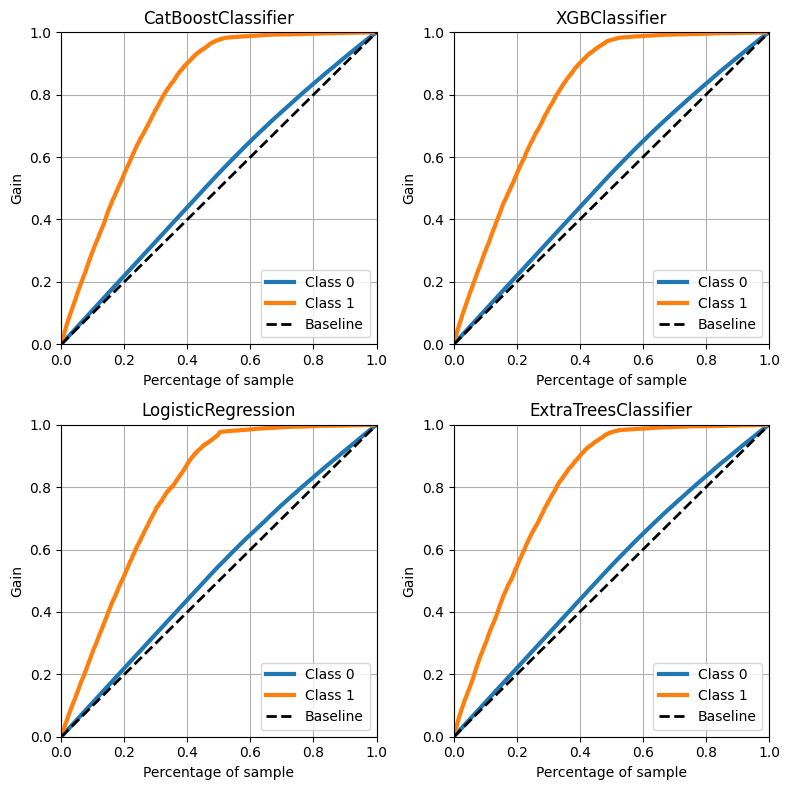

In [27]:
final_models = [cb2, xgb2, lr2, et2]

plot_cumulative_gain_of(final_models, X_test_rescaled, y_test, subx=2, suby=2,figsize=(8, 8))

I'll choose **`CatBoostClassifier 2`**. Because CatBoost handles better with categorical features and its metrics are good if we compare with the other models.

**Note:** XGBoost and Extra Trees would be good models too, their metrics are very close to CatBoost. I just have to choose one model by a determined criterion. Furthermore, the cumulative gain plot are very similar too:
- If we contact to **20\%** of all the sample, then we can get almost **60\%** of interest in vehicle insurance
- If we contact to **40\%** of all the sample, then we can get almost **90\%** of interest in vehicle insurance

In [28]:
# Training the best model
cb2.fit(X_train_rescaled, y_train_n, eval_set=[(X_test_rescaled, y_test_n)])

In [29]:
# Saving the best model - CatBoostClassifier
model_pkl_file = '../models/best-model.pkl'
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(cb2, file)

## 2.6. Feature Importances

### 2.6.1. Gini

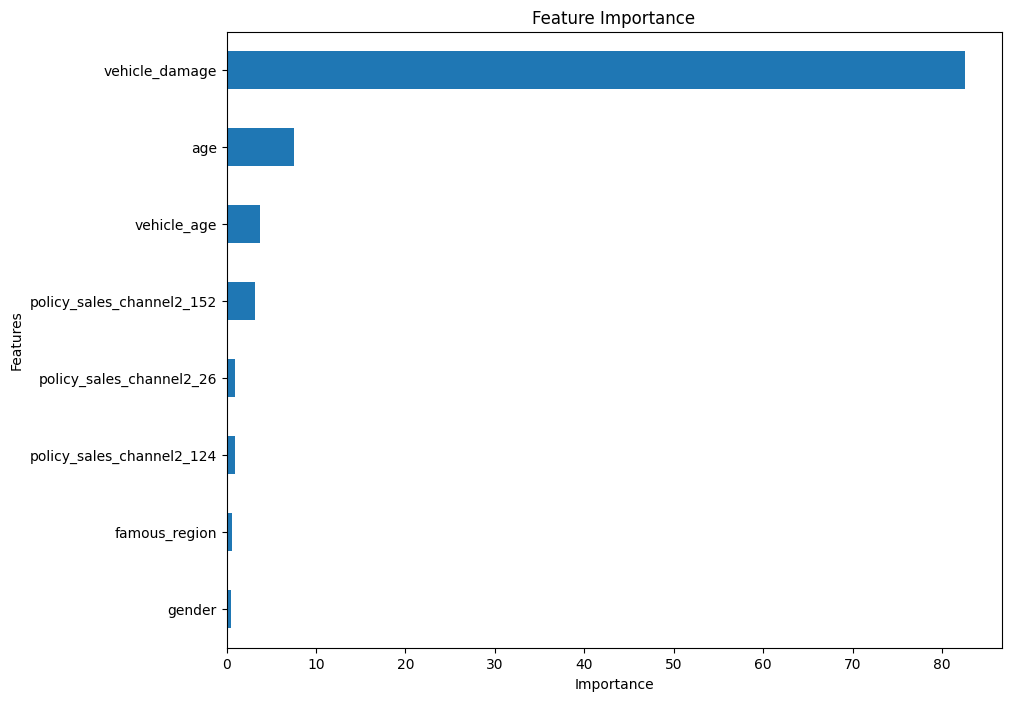

In [30]:
# Gini importances
rf_imp_features = pd.Series(cb2.feature_importances_, index=X_train_rescaled.columns)
rf_imp_features = rf_imp_features.sort_values()

# Plot
plt.figure(figsize=(10, 8))
rf_imp_features.plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

The most important feature was `vehicle_damage` and `age`.

### 2.6.2. SHAP

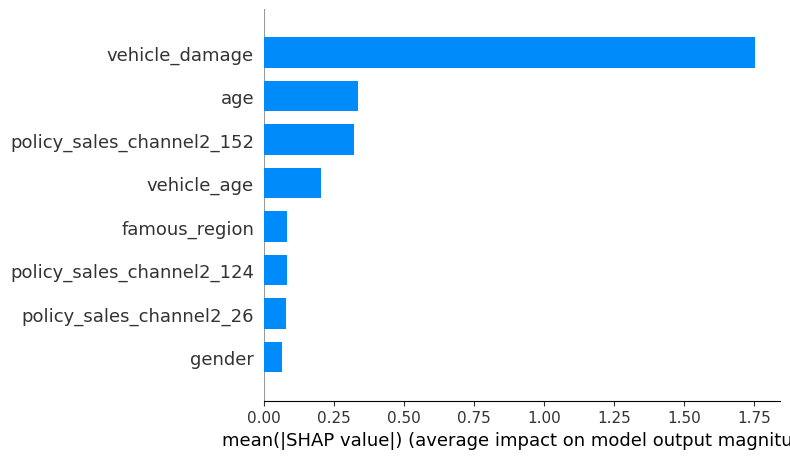

In [31]:
# Initialize explainer with the training data
explainer = shap.TreeExplainer(cb2)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_rescaled)

# SHAP feature importance plot
shap.summary_plot(shap_values, X_train_rescaled,
                  feature_names=X_train_rescaled.columns,
                  plot_type='bar')
plt.show()

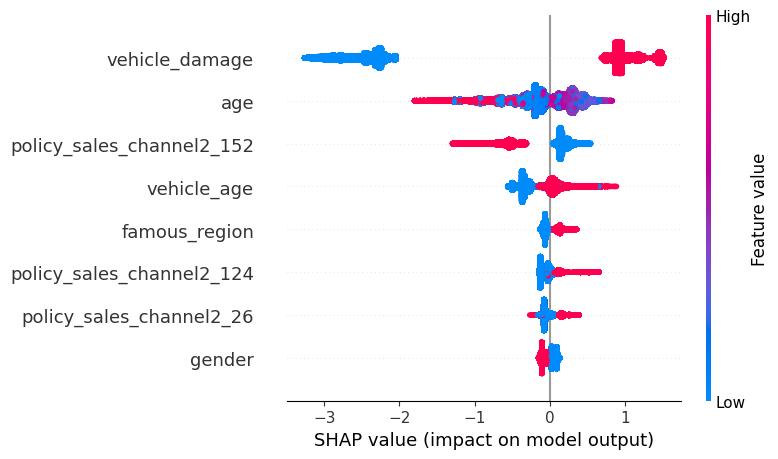

In [32]:
# SHAP beeswarm plot
shap.summary_plot(shap_values, X_train_rescaled,
                  feature_names=X_train_rescaled.columns)
plt.show()

**NOTES**
- If the customer **vehicle has been damaged**, then **more chances** to get interested in vehicle insurance
- If the **`policy_sales_channel = 152`**, then **less chances** to get interested in vehicle insurance
- If the **vehicle age is higher**, then **more chances** to get interested in vehicle insurance
- The **customer age** is an important feature for the model

## 2.7. Final metrics

In [ ]:
# Final results
final_results_df[final_results_df['model'] == 'CatBoostClassifier 2']

,model,roc_auc_cv,auc_test,precision_cv,precision_test,recall_cv,recall_test,f1_cv,f1_test
0,CatBoostClassifier 2,0.831 +/- 0.002,0.828,0.204 +/- 0.001,0.202,0.916 +/- 0.003,0.921,0.334 +/- 0.002,0.332


## 2.7. Saving the test predict

In [54]:
# Predict of test
y_pred = cb2.predict(X_test_rescaled)

# Create the DataFrame
df_predict = pd.DataFrame(columns=['id', 'response', 'predict', 'predict_proba'])

df_predict['id'] = X_test_ids
df_predict['response'] = y_test_n
df_predict['predict'] = y_pred
df_predict['predict_proba0'] = cb2.predict_proba(X_test_rescaled)[:, 1]

# Sort by predict_proba
df_predict = df_predict.sort_values('predict_proba', ascending=False).reset_index(drop=True)
df_predict.head()

,id,response,predict,predict_proba
0,207940.0,0,1,0.907196
1,480596.0,0,1,0.907123
2,406196.0,0,1,0.904750
3,95410.0,0,1,0.904750
4,398782.0,0,1,0.904667


In [55]:
# Save
df_predict.to_csv('../data/processed/df_predict.csv', index=False)